# QuTiP example: Homodyned Jaynes-Cummings emission

K.A. Fischer, Stanford University

This Jupyter notebook demonstrates how to simulate quantum statistics of homodyned emission from a detuned Jaynes-Cummings system. The
purpose is to understand how well the first polariton of a dissipative Jaynes-Cummings system can act as an ideal two-level system. This notebook closely follows an example from my simulation paper, <a href="https://arxiv.org/abs/1611.01566">An architecture for self-homodyned nonclassical light</a>, Phys. Rev. Applied 7, 044002 (2017).

For more information about QuTiP see the project web page: http://qutip.org/ 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from qutip import *

## Introduction for the two-level system

The quantum two-level system (TLS) is the simplest possible model for quantum light-matter interaction. In the version we simulate here, the system is driven by a continuous-mode coherent state, whose dipolar interaction with the system is represented by the following Hamiltonain

$$ H_\mathrm{TLS} =\hbar \omega_0 \sigma^\dagger \sigma + \frac{\hbar\Omega_\mathrm{TLS}(t)}{2}\left( \sigma\textrm{e}^{-i\omega_dt} + \sigma^\dagger \textrm{e}^{i\omega_dt}\right),$$

where $\omega_0$ is the system's transition frequency, $\sigma$ is the system's atomic lowering operator, $\omega_d$ is the coherent state's center frequency, and $\Omega_\mathrm{TLS}(t)$ is the coherent state's driving strength.

The time-dependence can be removed to simplify the simulation by a rotating frame transformation, and is particularly simple when the driving field is resonant with the transition frequency ($\omega_d=\omega_0$). Then,

$$ \tilde{H}_\mathrm{TLS} =\frac{\hbar\Omega(t)}{2}\left( \sigma+ \sigma^\dagger \right).$$

### Setup the two-level system properties

In [4]:
# define system operators
gamma = 1                           # decay rate
sm_TLS = destroy(2)                 # dipole operator
c_op_TLS = [np.sqrt(gamma)*sm_TLS]  # represents spontaneous emission

# choose range of driving strengths to simulate
Om_list_TLS = gamma*np.logspace(-2, 1, 300)

# calculate steady-state density matricies for the driving strengths
rho_ss_TLS = []
for Om in Om_list_TLS:
    H_TLS = Om * (sm_TLS + sm_TLS.dag())
    rho_ss_TLS.append(steadystate(H_TLS, c_op_TLS))

The emission can be decomposed into a so-called coherent and incoherent portion. The coherent portion is simply due to the classical mean of the dipole moment, i.e.

$$I_\mathrm{c}=\lim_{t\rightarrow\infty}\Gamma\langle\sigma^\dagger(t)\rangle\langle\sigma(t)\rangle,$$

while the incoherent portion is due to the standard deviation of the dipole moment (which represents its quantum fluctuations), i.e.

$$I_\mathrm{inc}=\lim_{t\rightarrow\infty}\Gamma\langle\sigma^\dagger(t)\sigma(t)\rangle-I_\mathrm{c}.$$

Together, these emissions conspire in a way to result in zero second-order coherence for the two-level system, i.e. $g^{(2)}(0)=0$.


In [5]:
# decompose the emitted light into the coherent and incoherent 
# portions
I_c_TLS = expect(sm_TLS.dag(), rho_ss_TLS)*expect(sm_TLS, rho_ss_TLS)
I_inc_TLS = expect(sm_TLS.dag()*sm_TLS, rho_ss_TLS) - I_c_TLS

### Visualize the incoherent and coherent emissions

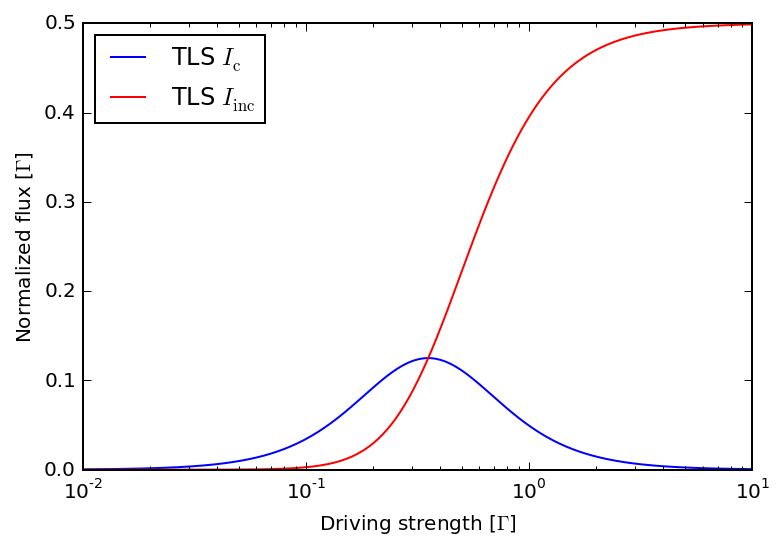

In [6]:
plt.semilogx(Om_list_TLS, abs(I_c_TLS), 
             label='TLS $I_\mathrm{c}$')
plt.semilogx(Om_list_TLS, abs(I_inc_TLS), 
             'r', label='TLS $I_\mathrm{inc}$')
plt.xlabel('Driving strength [$\Gamma$]')
plt.ylabel('Normalized flux [$\Gamma$]')
plt.legend(loc=2);

## Introduction for the Jaynes-Cummings system

The quantum Jaynes-Cummings (JC) system represents one of the most fundamental models for quantum light-matter interaction, which models the interaction between a quantum two-level system (e.g. an atomic transition) and a single photonic mode. Here, the strong interaction between light and matter creates new quantum states known as polaritons in an anharmonic ladder of states. In a phenomenon known as photon blockade, the most anharmonic polariton is used as a two-level system to produce emission with $g^{(2)}(0)<1$. We will investigate how well the emission compares to that of a two-level system by comparing both its coherent and incoherent components as well as its $g^{(2)}(0)$.

In the version we simulate here, the Jaynes-Cummings system is driven by a continuous-mode coherent state, whose dipolar interaction with the system is represented by the following Hamiltonain

$$ H =\hbar \omega_a a^\dagger a + \hbar \left(\omega_a+\Delta\right) \sigma^\dagger \sigma+ \hbar g\left(a^\dagger\sigma +a\sigma^\dagger\right) + \frac{\hbar\Omega(t)}{2}\left( a\textrm{e}^{-i\omega_dt} + a^\dagger \textrm{e}^{i\omega_dt}\right),$$

where additionally $\omega_a$ is the cavity's resonant frequency and $\Delta$ is the cavity-atom detuning. We will investigate for finite $\Delta$ because this increases the anharmonicity of the Jaynes-Cummings ladder. The time-dependence can additionally be removed to simplify the simulation by a rotating frame transformation in a very similar manner as before.

### Setup the JC system properties

In [7]:
# truncate size of cavity's Fock space
N = 15

# setup system operators
sm = tensor(destroy(2), qeye(N))
a = tensor(qeye(2), destroy(N))

# define system parameters, barely into strong coupling regime
kappa = 1
g = 0.6 * kappa
detuning = 3 * g  # cavity-atom detuning
delta_s = detuning/2 + np.sqrt(detuning ** 2 / 4 + g ** 2)

# we only consider cavities in the good-emitter limit, where 
# the atomic decay is irrelevant
c_op = [np.sqrt(kappa)*a]

### Effective polaritonic two-level system

In the ideal scenario, the most anharmonic polariton and the ground state form an ideal two-level system with effective emission rate of

$$\Gamma_\mathrm{eff}= \frac{\kappa}{2}+2\,\textrm{Im} \left\{\sqrt{ g^2-\left( \frac{\kappa}{4}+\frac{\textbf{i}\Delta}{2} \right)^2 }\right\}.$$

In [8]:
effective_gamma = kappa / 2 + 2 * np.imag(
    np.sqrt(g ** 2 - (kappa / 4 + 1j * detuning / 2) ** 2))

# set driving strength based on the effective polariton's 
# emission rate (driving strength goes as sqrt{gamma})
Om = 0.4 * np.sqrt(effective_gamma)

### Define reference system for homodyne interference

For the purposes of optimally homodyning the JC output, we wish to transmit light through a bare cavity (no atom involved) and calculate its coherent amplitude. (This of course could easily be analytically calculated but QuTiP certainly is trivially capable of such a calculation.)

In [9]:
# reference cavity operator
a_r = destroy(N)
c_op_r = [np.sqrt(kappa)*a_r]

# reference cavity Hamiltonian, no atom coupling
H_c = Om * (a_r + a_r.dag()) + delta_s * a_r.dag() * a_r

# solve for coherent state amplitude at driving strength Om
rho_ss_c = steadystate(H_c, c_op_r)
alpha = -expect(rho_ss_c, a_r)
alpha_c = alpha.conjugate()

### Calculate JC emission

The steady-state emitted flux from the JC system is given by $T=\kappa\langle a^\dagger a \rangle$, however with an additional homodyne interference it is $T=\langle b^\dagger b \rangle$, where the operator $b=\sqrt{\kappa}/2\, a + \beta$ is a new operator representing the interference between the JC emssion and a coherent state of amplitude $\beta$.

The interference present in the operator $b$ now allows for the alteration of the measured portion of the coherently scattered light, though it leaves the incoherent portion unchanged since the incident flux has only a coherent portion. We're interested in studying the optimal homodyne interference to allow the JC emission to match the TLS emission as closely as possible. This optimum is determined from the above reference cavity, such that $\beta=-\sqrt{\kappa}/2\langle a_\textrm{ref} \rangle$.

In [10]:
def calculate_rho_ss(delta_scan):
    H = Om * (a + a.dag()) + g * (sm.dag() * a + sm * a.dag()) + \
        delta_scan * (
            sm.dag() * sm + a.dag() * a) - detuning * sm.dag() * sm
    return steadystate(H, c_op)


delta_list = np.linspace(-6 * g, 9 * g, 200)
rho_ss = parfor(calculate_rho_ss, delta_list)

# calculate JC emission
I = expect(a.dag()*a, rho_ss)

# calculate JC emission homodyned with optimal state beta
I_int = expect((a.dag() + alpha_c) * (a + alpha), rho_ss)

### Visualize the emitted flux with and without interference

The dashed black line shows the intensity without interference and the violet line shows the intensity with interference. The vertical gray line indicates the spectral position of the anharmonic polariton. Note its narrower linewidth due to the slower effective decay rate (more atom-like since we're in the good-emitter limit).

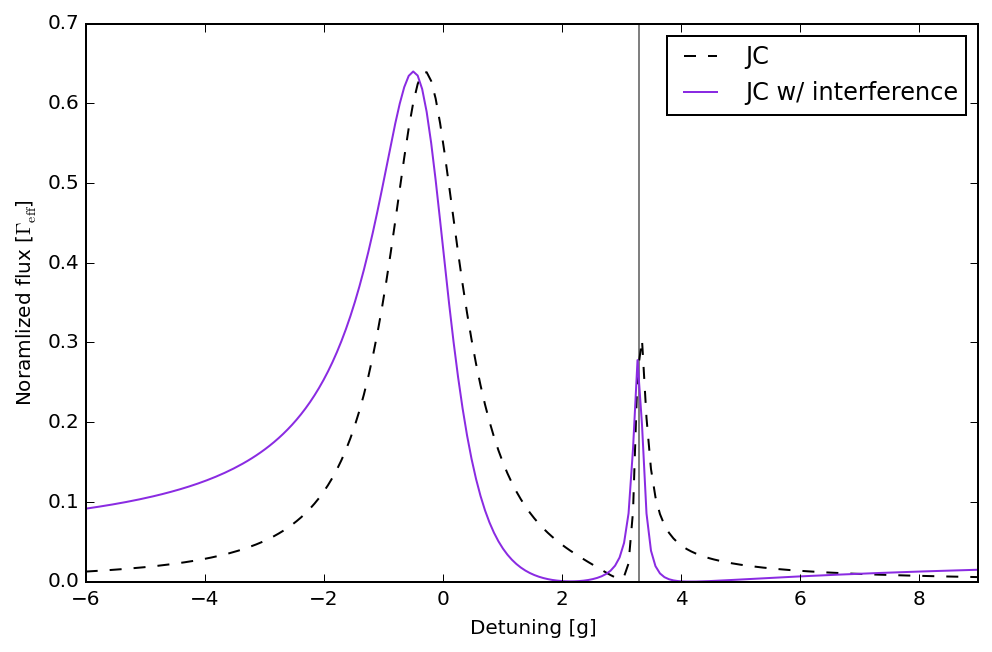

In [11]:
plt.figure(figsize=(8,5))

plt.plot(delta_list/g, I/effective_gamma,
         'k', linestyle='dashed', label='JC')
plt.plot(delta_list/g, I_int/effective_gamma,
         'blueviolet', label='JC w/ interference')
plt.vlines(delta_s/g, 0, 0.7, 'gray')
plt.xlim(-6, 9)
plt.ylim(0, 0.7)
plt.xlabel('Detuning [g]')
plt.ylabel('Noramlized flux [$\Gamma_\mathrm{eff}$]')
plt.legend(loc=1);

### Calculate coherent/incoherent portions of emission from JC system and its $g^{(2)}(0)$

We note that

$$g^{(2)}(0)=\frac{\langle a^\dagger a^\dagger a a \rangle}{\langle a^\dagger a \rangle^2}.$$

In [12]:
Om_list = kappa*np.logspace(-2, 1, 300)*np.sqrt(effective_gamma)

In [13]:
def calculate_rho_ss(Om):
    H = Om * (a + a.dag()) + g * (sm.dag() * a + sm * a.dag()) + \
        delta_s*(sm.dag()*sm + a.dag()*a) - detuning*sm.dag()*sm
    return steadystate(H, c_op)

rho_ss = parfor(calculate_rho_ss, Om_list)

# decompose emission again into incoherent and coherent portions
I_c = expect(a.dag(), rho_ss)*expect(a, rho_ss)
I_inc = expect(a.dag()*a, rho_ss) - I_c

# additionally calculate g^(2)(0)
g20 = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2

### Visualize the results

The dashed black line in the top figure represents the coherent portion of the emission and can clearly be seen to dominate the emission for large driving strengths. Here, the emission significantly deviates from that of a two-level system, which saturates by these driving strengths. The lack of saturation for the JC system occurs due to the harmonic ladder above the anharmonic polariton. Additionally, the $g^{(2)}(0)$ values are all quite large relative to the ideal TLS value of zero (bottom plot).

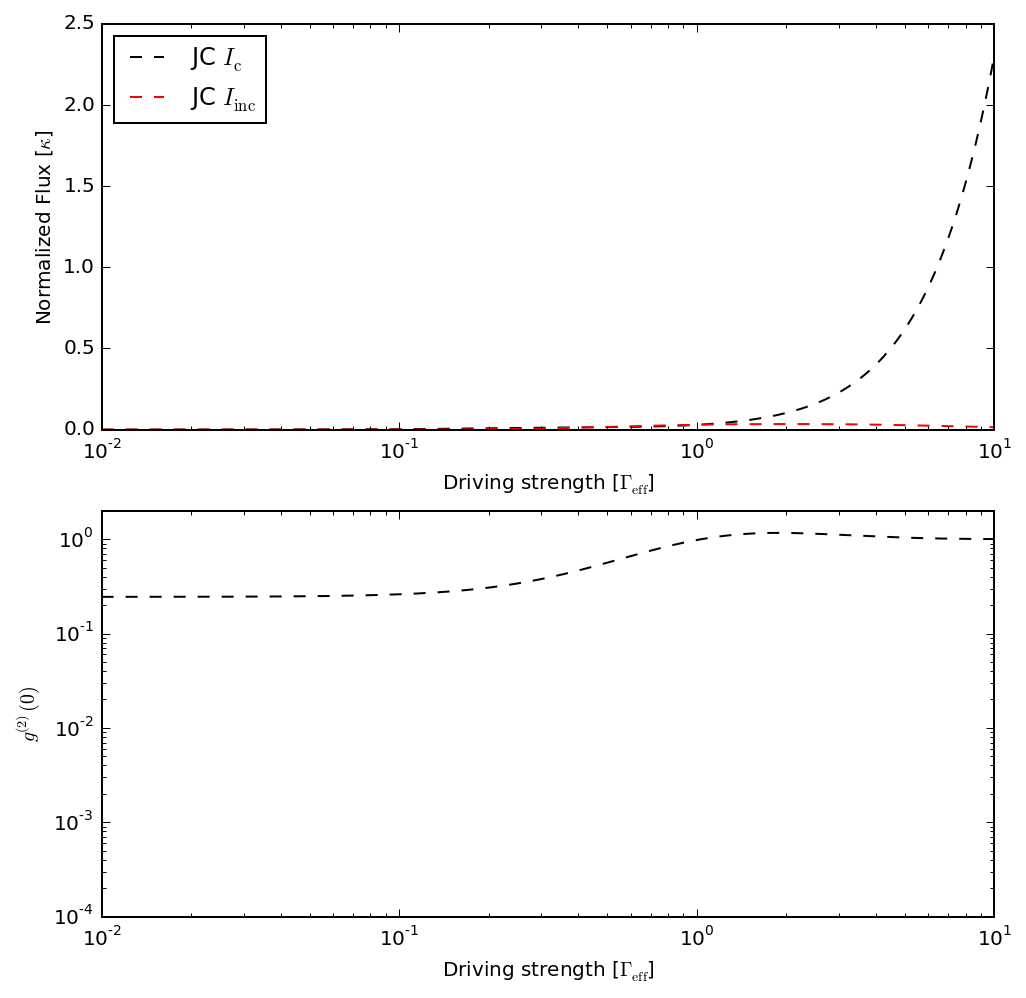

In [14]:
plt.figure(figsize=(8,8))

plt.subplot(211)
plt.semilogx(Om_list/np.sqrt(effective_gamma), abs(I_c)/kappa,
             'k', linestyle='dashed', label='JC $I_\mathrm{c}$')
plt.semilogx(Om_list/np.sqrt(effective_gamma), abs(I_inc)/kappa,
             'r', linestyle='dashed', label='JC $I_\mathrm{inc}$')
plt.xlabel(r'Driving strength [$\Gamma_\mathrm{eff}$]')
plt.ylabel('Normalized Flux [$\kappa$]')
plt.legend(loc=2)

plt.subplot(212)
plt.loglog(Om_list/np.sqrt(effective_gamma), g20,
           'k', linestyle='dashed')
lim = (1e-4, 2e0)
plt.ylim(lim)
plt.xlabel(r'Driving strength [$\Gamma_\mathrm{eff}$]')
plt.ylabel('$g^{(2)}(0)$');

### Calculate homodyned JC emission

Now we recalculate the coherent and incoherent portions as well as the $g^{(2)}(0)$ for the homodyned JC emission, but use the operator $b$ instead of $\sqrt{\kappa}/2\,a$. Thus

$$g^{(2)}(0)=\frac{\langle b^\dagger b^\dagger b b \rangle}{\langle b^\dagger b \rangle^2}.$$

In [15]:
def calculate_rho_ss_c(Om):
    H_c = Om * (a_r + a_r.dag()) + delta_s * a_r.dag() * a_r
    return steadystate(H_c, c_op_r)

rho_ss_c = parfor(calculate_rho_ss_c, Om_list)

# calculate list of interference values for all driving strengths
alpha_list = -expect(rho_ss_c, a_r)
alpha_c_list = alpha_list.conjugate()

# decompose emission for all driving strengths
g20_int = []
I_c_int = []
I_inc_int = []
for i, rho in enumerate(rho_ss):
    g20_int.append(
        expect((a.dag() + alpha_c_list[i]) * 
               (a.dag() + alpha_c_list[i]) * 
               (a + alpha_list[i]) * 
               (a + alpha_list[i]),
               rho) /
        expect((a.dag() + alpha_c_list[i]) * 
               (a + alpha_list[i]),
               rho)**2
    )
    I_c_int.append(expect(a.dag() + alpha_c_list[i], rho) * 
                   expect(a + alpha_list[i], rho))
    I_inc_int.append(expect(
            (a.dag() + alpha_c_list[i]) * 
            (a + alpha_list[i]), rho) - I_c_int[-1])

### Calculate the results

The dashed red and blue lines, which represent the TLS decomposition are now matched well by the JC decomposition with optimal homodyne interference (red and blue). The dashed black line is shown again as a reminder of the JC system's coherent emission without interference, which does not saturate for large driving strengths. Additionally, with the interference the $g^{(2)}(0)$ value improves by many orders of magnitude.

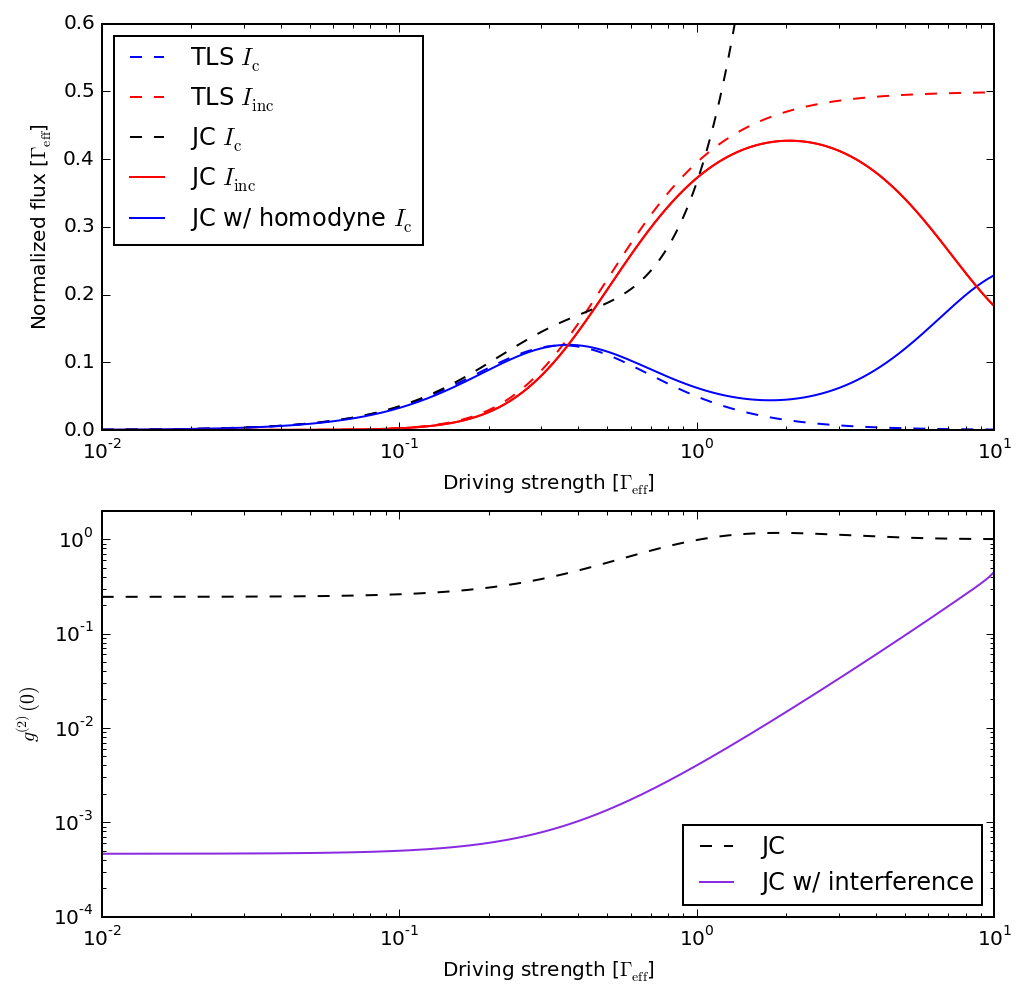

In [16]:
plt.figure(figsize=(8,8))

plt.subplot(211)
plt.semilogx(Om_list_TLS, abs(I_c_TLS),
             linestyle='dashed', label='TLS $I_\mathrm{c}$')
plt.semilogx(Om_list_TLS, abs(I_inc_TLS), 'r', 
             linestyle='dashed', label='TLS $I_\mathrm{inc}$')
plt.semilogx(Om_list/np.sqrt(effective_gamma),
             abs(I_c/effective_gamma), 'k', linestyle='dashed', 
             label='JC $I_\mathrm{c}$')
plt.semilogx(Om_list/np.sqrt(effective_gamma),
             abs(I_inc/effective_gamma), 
             'r', label='JC $I_\mathrm{inc}$')
plt.semilogx(Om_list/np.sqrt(effective_gamma),
             abs(I_c_int/effective_gamma),
             'b', label='JC w/ homodyne $I_\mathrm{c}$')
plt.semilogx(Om_list/np.sqrt(effective_gamma),
             abs(I_inc_int/effective_gamma),
             'r')
plt.ylim(5e-4, 0.6)
plt.xlabel(r'Driving strength [$\Gamma_\mathrm{eff}$]')
plt.ylabel('Normalized flux [$\Gamma_\mathrm{eff}$]')
plt.legend(loc=2)

plt.subplot(212)
plt.loglog(Om_list/np.sqrt(effective_gamma), g20,
           'k', linestyle='dashed', label='JC')
plt.loglog(Om_list/np.sqrt(effective_gamma), g20_int,
           'blueviolet', label='JC w/ interference')
plt.ylim(lim)
plt.xlabel(r'Driving strength [$\Gamma_\mathrm{eff}$]')
plt.ylabel(r'$g^{(2)}(0)$')
plt.legend(loc=4);

### Second-order coherence with delay

We additionally consider the second-order coherence as a function of time delay, i.e.

$$g^{(2)}(\tau)=\lim_{t\rightarrow\infty}\frac{\langle b^\dagger(t)b^\dagger(t+\tau)b(t+\tau)b(t)\rangle}{\langle b^\dagger(t)b(t)\rangle^2},$$

and show how it is calculated in the context of homodyne interference.

In [17]:
# first calculate the steady state
H = Om * (a + a.dag()) + g * (sm.dag() * a + sm * a.dag()) + \
    delta_s * (sm.dag() * sm + a.dag() * a) - \
    detuning * sm.dag() * sm
rho0 = steadystate(H, c_op)

taulist = np.linspace(0, 5/effective_gamma, 1000)

# next evolve the states according the quantum regression theorem

# ...with the b operator
corr_vec_int = expect(
    (a.dag() + alpha.conjugate()) * (a + alpha),
    mesolve(
        H, (a + alpha) * rho0 * (a.dag() + alpha.conjugate()),
        taulist, c_op, [],
        options=Options(atol=1e-13, rtol=1e-11)
    ).states
)
n_int = expect(rho0, (a.dag() + alpha.conjugate()) * (a + alpha))

# ...with the a operator
corr_vec = expect(
    a.dag() * a ,
    mesolve(
        H, a * rho0 * a.dag(),
        taulist, c_op, [],
        options=Options(atol=1e-12, rtol=1e-10)
    ).states
)
n = expect(rho0, a.dag() * a)

# ...perform the same for the TLS comparison
H_TLS = Om*(sm_TLS + sm_TLS.dag())*np.sqrt(effective_gamma)
c_ops_TLS = [sm_TLS*np.sqrt(effective_gamma)]
rho0_TLS = steadystate(H_TLS, c_ops_TLS)
corr_vec_TLS = expect(
    sm_TLS.dag() * sm_TLS,
    mesolve(
        H_TLS, sm_TLS * rho0_TLS * sm_TLS.dag(),
        taulist, c_ops_TLS, []
    ).states
)
n_TLS = expect(rho0_TLS, sm_TLS.dag() * sm_TLS)

### Visualize the comparison to TLS correlations

At a moderate driving strength, the JC correlation (dashed black line) is seen to significantly deviate from that of the TLS (dotted purple line). On the other hand, after the optimal homodyne inteference, the emission correlations (solid purple line) match the ideal correlations very well.

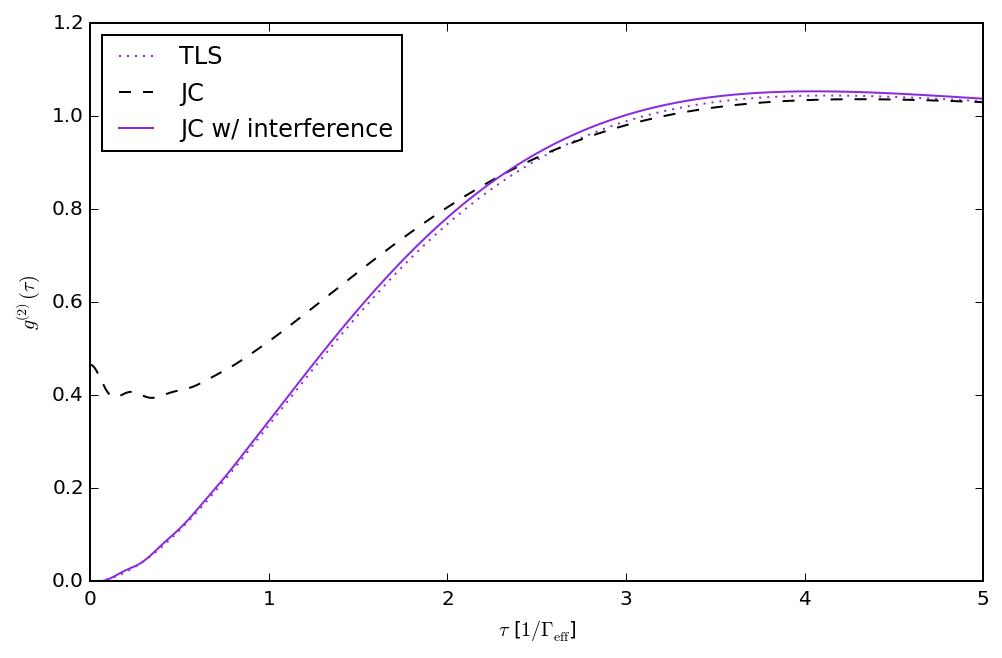

In [18]:
plt.figure(figsize=(8,5))

l1, = plt.plot(taulist*effective_gamma, corr_vec_TLS/n_TLS**2,
               'blueviolet', linestyle='dotted', label='TLS')
plt.plot(taulist*effective_gamma, corr_vec/n**2,
         'k', linestyle='dashed', label='JC')
plt.plot(taulist*effective_gamma, corr_vec_int/n_int**2,
         'blueviolet', label='JC w/ interference')
plt.xlabel('$\\tau$ [$1/\Gamma_\mathrm{eff}$]')
plt.ylabel('$g^{(2)}(\\tau)$')
plt.legend(loc=2);

## Versions

In [19]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.3.0.dev0+0f58c6f
Numpy,1.9.2
SciPy,0.18.1
matplotlib,1.4.3
Cython,0.24.1
Number of CPUs,8
BLAS Info,INTEL MKL
IPython,4.2.0
Python,"3.4.3 (default, Nov 17 2016, 01:08:31) [GCC 4.8.4]"
OS,posix [linux]
